# Writing a custom OpenAI Gym environment

*Prescriptum:* this is a tutorial on writing a custom OpenAI Gym environment that dedicates an unhealthy amount of text to selling you on the idea that you need a custom OpenAI Gym environment.
If you don't need convincing, [click here](#start). We assume decent knowledge of Python and next to no knowledge of Reinforcement Learning.

Reinforcement Learning arises in contexts where an agent (a robot or a software system):
- observes some data about its environment
- takes action in this environment
- receives rewards that indicate how  successful its actions have been

Say you have [200 million subscribers who want to receive movie recommendations](https://medium.com/inside-machine-learning/recommendation-systems-using-reinforcement-learning-de6379eecfde) and if the recommendations are good, they reward you with thumbs up, watch time and renewing their subscription[<sup>2</sup>](#fn2). Or you need [a program that decides which advertisement to show to the user so that they click](https://arxiv.org/abs/1909.03602). Or you have a spare [walking robot has to control its joints to avoid the negative reward for falling over](https://arxiv.org/pdf/1812.11103.pdf). In such an environment you can forgo programming/developing a strategy for your system and instead use on of the [industry standard reinforcement learning algorithms](http://www.incompleteideas.net/book/the-book-2nd.html) to learn a good strategy by trial and error.

These algorithms are very accessible - there are software packages available like [keras-rl](https://github.com/keras-rl/keras-rl) and, of course, [cibi](https://github.com/vadim0x60/cibi)[<sup>1</sup>](#fn1) - all that's left is to plug your problem into their code and watch the neural network slooooowly become an expert in solving your problem. These packages, however, aren't written for your marketing software. They are written for this:

<table>
    <tr>
        <td><img src="HeartPole-stuff/MountainCar.gif"></td>
        <td><img src="HeartPole-stuff/FetchPickAndPlace.gif"></td>
    </tr>
    <tr>
        <td><a href="https://gym.openai.com/envs/MountainCarContinuous-v0/">MountainCarContinuous-v0</a></td>
        <td><a href="https://gym.openai.com/envs/FetchPickAndPlace-v0/">FetchPickAndPlace-v0</a></td>
    </tr>
</table>

The images above are visualizations of environments from [OpenAI Gym](https://github.com/openai/gym) - a python library used as defacto standard for describing reinforcement learning tasks. In addition to [an array of environments to play with](https://gym.openai.com/envs/), OpenAI Gym provides us with tools to streamline development of new environments, promising us a future [so bright you'll have to wear shades](https://www.youtube.com/watch?v=8qrriKcwvlY) where there's no need to solve problems. Just define the problem as an OpenAI environment - and *keras-rl* will do the solving.

<span id="fn1"><sup>1</sup>The author of this tutorial is the author of [cibi](https://github.com/vadim0x60/cibi), but will pinky swear that this recommendation is unbiased if necessary</span><br>
<span id="fn2"><sup>2</sup>If you do, not sure why you are taking business advice from a free tutorial, but you're welcome</span>

## OpenAI Gym
<a id='start'></a>


But first, let us examine what a Gym environment looks like:

In [1]:
!pip install gym

You are using pip version 19.0.3, however version 20.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import gym

mountaincar = gym.make('MountainCarContinuous-v0') 

Gym environments follow the framework known as **Partially Observable Markov Decision Process** (source for [science historians](https://lup.lub.lu.se/search/publication/8867084), source [for dummies](http://cs.brown.edu/research/ai/pomdp/tutorial/)[<sup>3</sup>](#fn3)):

In [3]:
observation = mountaincar.reset()
location, speed = observation
print(f'location {location}, speed {speed}')

for step in range(5):
    observation, reward, done, _ = mountaincar.step(mountaincar.action_space.sample())
    location, speed = observation
    print(f'location {location}, speed {speed}')

location -0.5685406148970669, speed 0.0
location -0.5688027315981141, speed -0.00026211670104722885
location -0.5698682275165934, speed -0.0010654959184792792
location -0.5713767655566487, speed -0.0015085380400553488
location -0.5712982133534736, speed 7.855220317512469e-05
location -0.56988861109046, speed 0.0014096022630136558


The code above:
1. Initializes the MountainCar environment with `mountaincar.reset()`
2. Outputs the observed information (location and speed of the car)
3. Picks a random action form the space of actions possible in this environment - *action space* - with `mountaincar.action_space.sample()`
4. Sends this decision to the environment with `mountaincar.step()` 
5. Outputs the newly observed information
6. Repeats steps 3-5 5 times

Every environment has to follow this pattern. The environments only differ in their
1. Action space
2. Observation space
3. Implementation of `env.step()` function

One can explore the environment action and observation spaces as follows:

In [4]:
mountaincar.action_space

Box(1,)

In [5]:
mountaincar.action_space.low

array([-1.], dtype=float32)

In [6]:
mountaincar.action_space.high

array([1.], dtype=float32)

In [7]:
mountaincar.action_space.sample()

array([-0.8745458], dtype=float32)

In [8]:
mountaincar.observation_space

Box(2,)

In [9]:
mountaincar.observation_space.sample()

array([-0.4532412 , -0.02371772], dtype=float32)

In [10]:
location_low, speed_low = mountaincar.observation_space.low
location_high, speed_high = mountaincar.observation_space.high

print(f'Car location can range from {location_low} to {location_high}')
print(f'Car speed can range from {speed_low} to {speed_high}')

Car location can range from -1.2000000476837158 to 0.6000000238418579
Car speed can range from -0.07000000029802322 to 0.07000000029802322


Notice how this space is just a pair (a numpy array of shape `(2,)` to be precise) of numbers with no indication what they mean. You can find out that the first number is car location and the second number is car speed is taken from the environment's [source code](https://gym.openai.com/envs/MountainCarContinuous-v0) or from the original [PhD thesis describing it](https://www.cl.cam.ac.uk/techreports/UCAM-CL-TR-209.pdf). But the environment abstracts this away as an unimportant detail. That's because for a reinforcement learning algorithm it is an unimportant detail - it will learn how to interpret these numbers on its own oevr the course of training

In total, there are 4 types of action/observation spaces ([the docs mention just the first two](https://gym.openai.com/docs/#spaces), but [the code never lies](https://github.com/openai/gym/tree/master/gym/spaces)):
1. `Discrete(n)` - the action/observation is one of integer numbers $0,1,\dots,n-1$  
2. `Box(lower_bounds, upper_bounds)` where `lower_bounds` and `upper_bounds` are tensors of the same `shape`. The action/observation is a tensor (a numpy array) of shape `shape` and its components are real numbers in the `[lower_bound;upper_bound]` interval
3. `MultiBinary(n)` - the action/observation is an array of length `n` where each component is 0 or 1
4. `MultiDiscrete(nvec)` - the action/observation is an array of length `len(nvec)` and its k-th component is one of integer numbers $0,1,\dots,\text{nvec}_k-1$  

<span id="fn3"><sup>3</sup>The author of this tutorial tends to identify with the latter category</span>

## Meet HeartPole

**Disclaimer** the healthcare scenario presented here is not in any way based on anyone's real life experience

The go to environment for first experiments in Reinforcement Learning is [CartPole](https://gym.openai.com/envs/CartPole-v0/):

<img src="HeartPole-stuff/CartPole.gif">

The agent observes the position of the black cart and its velocity, as well as the angle of the pole and its angular velocity. The agent has to push the cart right or left so that the Pole doesn't fall.

But what if instead of balancing a wooden stick on a cart you were balancing your health and your creative productivity?

Consider the following facts (or, rather, 7 facts and 1 fiction):

**Fact 0**. Your productivity and health depends on factors like 
- being sleepy v.s. alert
- blood pressure
- whether you are drunk
- how long ago has you last slept

In [11]:
state = {
    'alertness': 0,
    'hypertension': 0,
    'intoxication': 0,
    'time_since_slept': 10,
    'time_elapsed': 0,
    'work_done': 0
}

**Fact 1.** After a good night's sleep you wake up quite alert (but with some random variance).

In [12]:
import numpy as np

def wakeup(state):
    state['alertness'] = np.random.uniform(0.7, 1.3)
    state['time_since_slept'] = 0

In [13]:
wakeup(state)
state

{'alertness': 1.0329057949505636,
 'hypertension': 0,
 'intoxication': 0,
 'time_since_slept': 0,
 'time_elapsed': 0,
 'work_done': 0}

**Fact 2.**  Caffeine increases your alertness level and blood pressure

In [14]:
def drink_coffee(state):
    state['alertness'] += np.random.uniform(0, 1)
    state['hypertension'] += np.random.uniform(0, 0.3)

In [15]:
drink_coffee(state)
state

{'alertness': 1.2121581691372958,
 'hypertension': 0.026540110860619092,
 'intoxication': 0,
 'time_since_slept': 0,
 'time_elapsed': 0,
 'work_done': 0}

**Fact 3.** Alcohol decreases your alertness level, increases intoxication and blood pressure

In [16]:
def drink_beer(state):
    state['alertness'] -= np.random.uniform(0, 0.5)
    state['hypertension'] += np.random.uniform(0, 0.3)
    # source https://attorneydwi.com/b-a-c-per-drink/
    state['intoxication'] += np.random.uniform(0.01, 0.03)

In [17]:
drink_beer(state)
state

{'alertness': 1.0961084273124981,
 'hypertension': 0.07962840532275443,
 'intoxication': 0.028656779871043765,
 'time_since_slept': 0,
 'time_elapsed': 0,
 'work_done': 0}

**Fact 4.**  Hypertension is a risk factor for heart attacks

In [18]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def heart_attack_risk(hypertension):
    return sigmoid(hypertension - 6)

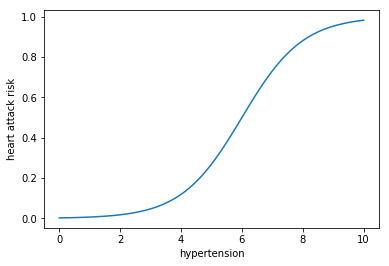

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

xspace = np.linspace(0, 10, 100)
plt.xlabel('hypertension')
plt.ylabel('heart attack risk')
plt.plot(xspace, heart_attack_risk(xspace))

In [20]:
def heart_attack_occured(state):
    return np.random.uniform(0, 1) < heart_attack_risk(state['hypertension'])
heart_attack_occured(state)

False

**Fact 5.** Hypertension and intoxication decay exponentially over time, with a half-life of around 12 hours (24 half-hours)

**Fact 6.** Alertness decays if you haven't slept for a long time

In [21]:
def alertness_decay(time_since_slept):
    return sigmoid((time_since_slept - 40) / 10)

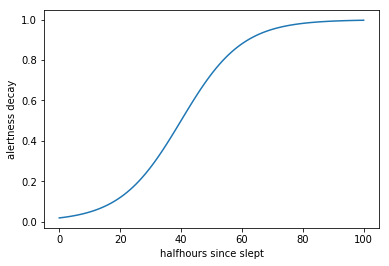

In [22]:
xspace = np.linspace(0, 100, 100)
plt.xlabel('halfhours since slept')
plt.ylabel('alertness decay')
plt.plot(xspace, alertness_decay(xspace))

In [23]:
decay_rate = 0.97
half_life = decay_rate ** 24
half_life

0.48141722191172337

In [24]:
def half_hour_passed(state):
    state['alertness'] -= alertness_decay(state['time_since_slept'])
    state['hypertension'] = decay_rate * state['hypertension']
    state['intoxication'] = decay_rate * state['intoxication']
    state['time_since_slept'] += 1
    state['time_elapsed'] += 1

In [25]:
half_hour_passed(state)
state

{'alertness': 1.0781222173504066,
 'hypertension': 0.0772395531630718,
 'intoxication': 0.02779707647491245,
 'time_since_slept': 1,
 'time_elapsed': 1,
 'work_done': 0}

**Fact 7**. In order to work productively, you have to be alert, but not so alert that crippling anxiety hits

In [26]:
def crippling_anxiety(alertness):
    return sigmoid(alertness - 3)

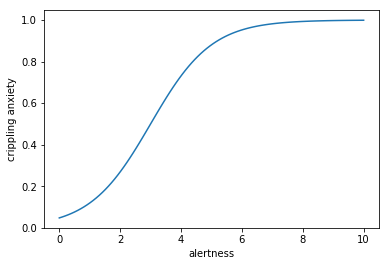

In [27]:
xspace = np.linspace(0, 10, 100)
plt.xlabel('alertness')
plt.ylabel('crippling anxiety')
plt.plot(xspace, crippling_anxiety(xspace))

**Fiction 8**. Relationship between intoxication level and productivity is modelled by the [Ballmer function](https://xkcd.com/323/):

![Ballmer function](https://imgs.xkcd.com/comics/ballmer_peak.png)

In [28]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def ballmer_function(intoxication):
    return sigmoid((0.05 - intoxication) * 50) + 2 * gaussian(intoxication, 0.135, 0.005)

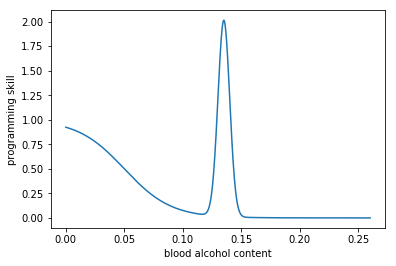

In [29]:
xspace = np.linspace(0, 0.26, 1000)
plt.xlabel('blood alcohol content')
plt.ylabel('programming skill')
plt.plot(xspace, ballmer_function(xspace))

In [30]:
def productivity(state):
    p = 1
    p *= state['alertness']
    p *= 1 - crippling_anxiety(state['alertness'])
    p *= ballmer_function(state['intoxication'])
    return p

In [31]:
state

{'alertness': 1.0781222173504066,
 'hypertension': 0.0772395531630718,
 'intoxication': 0.02779707647491245,
 'time_since_slept': 1,
 'time_elapsed': 1,
 'work_done': 0}

In [32]:
productivity(state)

0.7074011180655507

In [33]:
def work(state):
    state['work_done'] += productivity(state)
    half_hour_passed(state)

In [34]:
work(state)
state

{'alertness': 1.0582819116163291,
 'hypertension': 0.07492236656817963,
 'intoxication': 0.026963164180665074,
 'time_since_slept': 2,
 'time_elapsed': 2,
 'work_done': 0.7074011180655507}

Hopefully, the powers of Reinforcement Learning will help us improve this state!

## Writing the environment class

To write own OpenAI gym environment, you have to:
- Create a class that inherits from `gym.Env`
- Make sure that it has `action_space` and `observation_space` attributes defined
- Make sure it has `reset()`, `step()`, `close()` and `render()` functions defined. See our exploration of MountainCar above for an intuition on how this functions are supposed to work 

Let's do that, shall we?

First, we need to decide what the action and observation spaces of HeartPole are going to look like.

Every half an hour of working you stop and do one of the following:

1. Nothing
2. Drink coffee
3. Drink beer
4. Go to sleep

If you've chosen 1-3, you immediately go back to work, if you've chosen sleep, you sleep for 16 half-hours and go back to work

In [35]:
def do_nothing(state):
    pass

def sleep(state):
    """Have 16 half-hours of healthy sleep"""
    for hh in range(16):
        half_hour_passed(state)
    wakeup(state)

actions = [do_nothing, drink_coffee, drink_beer, sleep]

So, it is a 4-way discrete action space

In [36]:
heartpole_action_space = gym.spaces.Discrete(len(actions))

As for the observations, we observe the state of the patient, which is the following:

In [37]:
state

{'alertness': 1.0582819116163291,
 'hypertension': 0.07492236656817963,
 'intoxication': 0.026963164180665074,
 'time_since_slept': 2,
 'time_elapsed': 2,
 'work_done': 0.7074011180655507}

So, it's a `Box` of shape `(6,)`

In [38]:
observations = ['alertness', 'hypertension', 'intoxication',
                    'time_since_slept', 'time_elapsed', 'work_done']

def make_heartpole_obs_space():
    lower_obs_bound = {
        'alertness': - np.inf,
        'hypertension': 0,
        'intoxication': 0,
        'time_since_slept': 0,
        'time_elapsed': 0,
        'work_done': - np.inf
    }
    higher_obs_bound = {
        'alertness': np.inf,
        'hypertension': np.inf,
        'intoxication': np.inf,
        'time_since_slept': np.inf,
        'time_elapsed': np.inf,
        'work_done': np.inf
    }

    low = np.array([lower_obs_bound[o] for o in observations])
    high = np.array([higher_obs_bound[o] for o in observations])
    shape = (len(observations),)
    return gym.spaces.Box(low,high,shape)

Aaaaaaaaaaand, *voila!*

In [39]:
class HeartPole(gym.Env):
    def __init__(self):
        self.actions = actions
        self.observations = observations
        self.action_space = heartpole_action_space
        self.observation_space = make_heartpole_obs_space()
        self.log = ''
        
    def observation(self):
        return np.array([self.state[o] for o in self.observations])
        
    def reset(self):
        self.state = {
            'alertness': 0,
            'hypertension': 0,
            'intoxication': 0,
            'time_since_slept': 0,
            'time_elapsed': 0,
            'work_done': 0
        }
        
        wakeup(self.state)
        return self.observation()
        
    def step(self, action):
        if self.state['time_elapsed'] == 0:
            old_score = 0
        else:
            old_score = self.state['work_done'] / self.state['time_elapsed']
        
        # Do selected action
        self.actions[action](self.state)
        self.log += f'Chosen action: {self.actions[action].__name__}\n'
        
        # Do work
        work(self.state)
        
        new_score = self.state['work_done'] / self.state['time_elapsed']
        
        reward = new_score - old_score
        
        if heart_attack_occured(self.state):
            # We would like to avoid this
            reward -= 100
            
        self.log += str(self.state) + '\n'
        return self.observation(), reward, False, {}
    
    def close(self):
        pass
        
    def render(self, mode=None):
        print(self.log)
        self.log = ''

And that's it! Let's do what we did with MountainCar and test this Env with a random agent

In [40]:
heartpole = HeartPole()

/home/vadim0x60/.pyenv/versions/3.7.4/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [41]:
observation = heartpole.reset()
heartpole.render()

for step in range(5):
    observation, reward, done, _ = heartpole.step(heartpole.action_space.sample())
    heartpole.render()


Chosen action: sleep
{'alertness': 0.9919097993185104, 'hypertension': 0.0, 'intoxication': 0.0, 'time_since_slept': 1, 'time_elapsed': 17, 'work_done': 0.8210632206006916}

Chosen action: do_nothing
{'alertness': 0.972069493584433, 'hypertension': 0.0, 'intoxication': 0.0, 'time_since_slept': 2, 'time_elapsed': 18, 'work_done': 1.6292355997785772}

Chosen action: drink_beer
{'alertness': 0.6265535634765008, 'hypertension': 0.14598872324011872, 'intoxication': 0.025074010031526286, 'time_since_slept': 3, 'time_elapsed': 19, 'work_done': 2.0850385816744708}

Chosen action: sleep
{'alertness': 1.155350282074559, 'hypertension': 0.08698388341615793, 'intoxication': 0.01493974820076029, 'time_since_slept': 1, 'time_elapsed': 36, 'work_done': 2.9435022012044034}

Chosen action: do_nothing
{'alertness': 1.1355099763404815, 'hypertension': 0.08437436691367318, 'intoxication': 0.01449155575473748, 'time_since_slept': 2, 'time_elapsed': 37, 'work_done': 3.793825035618057}



## Registering the environment

The only difference left between "official" gym environments and our `HeartPole` is that bundled environemnts have an id string like `CartPole-v0` and can be created with `gym.make`. If you insist, this too can be rectified. For that you need to put your environment into a Python file and specify the entry point in the format of `module:Class`.

In [42]:
# Making it official
gym.register('HeartPole-v0', entry_point='heartpole:HeartPole')
heartpole = gym.make('HeartPole-v0')

In [43]:
observation = heartpole.reset()
heartpole.render()

for step in range(5):
    observation, reward, done, _ = heartpole.step(heartpole.action_space.sample())
    heartpole.render()


Chosen action: drink_coffee
{'alertness': 1.642777600188462, 'hypertension': 0.026270791962640656, 'intoxication': 0.0, 'time_since_slept': 1, 'time_elapsed': 1, 'work_done': 1.2161059103519332}

Chosen action: drink_beer
{'alertness': 1.5740047363998722, 'hypertension': 0.05195982316457359, 'intoxication': 0.027289255059966554, 'time_since_slept': 2, 'time_elapsed': 2, 'work_done': 2.174921120150138}

Chosen action: drink_beer
{'alertness': 1.4366015173862539, 'hypertension': 0.11583566987903755, 'intoxication': 0.04184447914598819, 'time_since_slept': 3, 'time_elapsed': 3, 'work_done': 2.877622190453214}

Chosen action: do_nothing
{'alertness': 1.4124744959685847, 'hypertension': 0.11236059978266642, 'intoxication': 0.04058914477160854, 'time_since_slept': 4, 'time_elapsed': 4, 'work_done': 3.5909850093827362}

Chosen action: drink_beer
{'alertness': 1.2438285660158293, 'hypertension': 0.11785322552113489, 'intoxication': 0.06012642340417647, 'time_since_slept': 5, 'time_elapsed': 5

## Testing the environment

In [44]:
!pip install keras-rl

You are using pip version 19.0.3, however version 20.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


To test this environment, let us use `keras-rl` to build a [SARSA](https://en.wikipedia.org/wiki/State–action–reward–state–action) agent with a simple feed-forward Q-network. Feel free to play around with the model and swap out the layers if you know what you're doing or just copy and paste the model [from one of the examples](https://github.com/keras-rl/keras-rl/blob/master/examples) if you don't. This model is from `sarsa-cartpole` [example](https://github.com/keras-rl/keras-rl/blob/master/examples/sarsa_cartpole.py)

In [45]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents import SARSAAgent
from rl.policy import BoltzmannQPolicy

def create_sarsa_model_for(env):
    # We build a very simple model.
    model = Sequential()
    model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(env.action_space.n))
    model.add(Activation('linear'))
    print(model.summary())
    
    # SARSA does not require a memory.
    policy = BoltzmannQPolicy()
    sarsa = SARSAAgent(model=model, 
                       nb_actions=env.action_space.n, 
                       nb_steps_warmup=10, policy=policy)
    sarsa.compile(Adam(lr=1e-3), metrics=['mae'])
    
    return sarsa

Using TensorFlow backend.


In [57]:
sarsa = create_sarsa_model_for(heartpole)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 6)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                112       
_________________________________________________________________
activation_9 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
activation_10 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                272       
_________________________________________________________________
activation_11 (Activation)   (None, 16)               

Time to train our agent! Not that SARSA trains in _episodes_ - it takes actions in the environment until the `done` variable becomes true. When it does, the episode is considered to have finished and updates are made to the policy to perform better next episode.

Our `HeartPole` environment is infinite and never returns `done=True` (why would you ever stop working?). That's why we set `nb_max_episode_steps` to `1000` so that the agent terminates the episode after 1000 steps.

In [58]:
# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
sarsa.fit(heartpole, nb_steps=300000,
          nb_max_episode_steps=1000, visualize=False, verbose=2)

Training for 300000 steps ...
   1000/300000: episode: 1, duration: 4.803s, episode steps: 1000, steps per second: 208, episode reward: -399.965, mean reward: -0.400 [-100.001, 0.410], mean action: 2.540 [0.000, 3.000], mean observation: 1260.415 [-12.124, 13848.000], loss: 22.375533, mae: 133.659883, mean_q: 295.100736
   2000/300000: episode: 2, duration: 4.227s, episode steps: 1000, steps per second: 237, episode reward: -299.913, mean reward: -0.300 [-100.005, 0.052], mean action: 1.288 [0.000, 3.000], mean observation: 495.636 [-5.800, 7864.000], loss: 15.227278, mae: 62.714941, mean_q: -17.149305
   3000/300000: episode: 3, duration: 4.403s, episode steps: 1000, steps per second: 227, episode reward: -500.076, mean reward: -0.500 [-100.002, 0.444], mean action: 2.506 [0.000, 3.000], mean observation: 1177.637 [-1340.481, 14312.000], loss: 25.796280, mae: 290.538257, mean_q: -32.402672
   4000/300000: episode: 4, duration: 4.293s, episode steps: 1000, steps per second: 233, episod

  30000/300000: episode: 30, duration: 4.889s, episode steps: 1000, steps per second: 205, episode reward: -501.593, mean reward: -0.502 [-100.013, 0.728], mean action: 1.176 [0.000, 3.000], mean observation: 305.428 [-7184.733, 4504.000], loss: 405.649144, mae: 78.358935, mean_q: -84.330865
  31000/300000: episode: 31, duration: 4.971s, episode steps: 1000, steps per second: 201, episode reward: -900.640, mean reward: -0.901 [-100.015, 0.707], mean action: 1.263 [0.000, 3.000], mean observation: 420.546 [-3109.316, 4856.000], loss: 59.714775, mae: 13.214842, mean_q: -13.194133
  32000/300000: episode: 32, duration: 4.948s, episode steps: 1000, steps per second: 202, episode reward: -299.872, mean reward: -0.300 [-100.001, 1.003], mean action: 1.149 [0.000, 3.000], mean observation: 345.829 [-2.307, 4424.000], loss: 16.091768, mae: 10.297096, mean_q: -11.264124
  33000/300000: episode: 33, duration: 4.907s, episode steps: 1000, steps per second: 204, episode reward: -602.541, mean rewa

  59000/300000: episode: 59, duration: 5.805s, episode steps: 1000, steps per second: 172, episode reward: -199.994, mean reward: -0.200 [-100.010, 0.620], mean action: 2.686 [0.000, 3.000], mean observation: 1317.772 [-76.000, 15240.000], loss: 10.159038, mae: 37.573367, mean_q: -10.223344
  60000/300000: episode: 60, duration: 5.753s, episode steps: 1000, steps per second: 174, episode reward: -1300.327, mean reward: -1.300 [-100.018, 0.613], mean action: 1.362 [0.000, 3.000], mean observation: 268.055 [-1607.318, 4200.000], loss: 65.011761, mae: 3.519944, mean_q: -0.494808
  61000/300000: episode: 61, duration: 5.797s, episode steps: 1000, steps per second: 172, episode reward: -500.036, mean reward: -0.500 [-100.008, 0.615], mean action: 1.257 [0.000, 3.000], mean observation: 434.117 [-368.638, 4408.000], loss: 25.149632, mae: 8.452579, mean_q: -5.373467
  62000/300000: episode: 62, duration: 5.818s, episode steps: 1000, steps per second: 172, episode reward: -299.873, mean reward

  88000/300000: episode: 88, duration: 6.973s, episode steps: 1000, steps per second: 143, episode reward: -499.950, mean reward: -0.500 [-100.000, 0.501], mean action: 2.870 [0.000, 3.000], mean observation: 1298.297 [-0.298, 15816.000], loss: 27.172715, mae: 23.274968, mean_q: -10.083420
  89000/300000: episode: 89, duration: 6.980s, episode steps: 1000, steps per second: 143, episode reward: -499.988, mean reward: -0.500 [-100.000, 0.530], mean action: 1.574 [0.000, 3.000], mean observation: 544.478 [-77.945, 6328.000], loss: 25.285449, mae: 8.803166, mean_q: -7.207062
  90000/300000: episode: 90, duration: 6.820s, episode steps: 1000, steps per second: 147, episode reward: -499.940, mean reward: -0.500 [-100.000, 0.054], mean action: 2.049 [0.000, 3.000], mean observation: 668.217 [-3.577, 9912.000], loss: 25.136200, mae: 28.519726, mean_q: -13.788113
  91000/300000: episode: 91, duration: 6.767s, episode steps: 1000, steps per second: 148, episode reward: -400.794, mean reward: -0

 117000/300000: episode: 117, duration: 7.621s, episode steps: 1000, steps per second: 131, episode reward: -99.947, mean reward: -0.100 [-100.000, 1.178], mean action: 2.314 [0.000, 3.000], mean observation: 999.657 [-10.712, 13128.000], loss: 5.467937, mae: 21.887083, mean_q: -16.683224
 118000/300000: episode: 118, duration: 7.614s, episode steps: 1000, steps per second: 131, episode reward: -599.935, mean reward: -0.600 [-100.001, 0.365], mean action: 2.416 [0.000, 3.000], mean observation: 992.563 [0.000, 13304.000], loss: 30.852373, mae: 32.241174, mean_q: -24.148508
 119000/300000: episode: 119, duration: 7.681s, episode steps: 1000, steps per second: 130, episode reward: -199.949, mean reward: -0.200 [-100.000, 0.871], mean action: 2.423 [0.000, 3.000], mean observation: 776.979 [-3.035, 8536.000], loss: 10.332850, mae: 13.284064, mean_q: -7.685673
 120000/300000: episode: 120, duration: 7.898s, episode steps: 1000, steps per second: 127, episode reward: -599.951, mean reward: 

 146000/300000: episode: 146, duration: 33.542s, episode steps: 1000, steps per second: 30, episode reward: -199.952, mean reward: -0.200 [-100.000, 0.988], mean action: 2.970 [0.000, 3.000], mean observation: 1449.226 [0.000, 16776.000], loss: 10.787952, mae: 87.440389, mean_q: -28.371845
 147000/300000: episode: 147, duration: 31.889s, episode steps: 1000, steps per second: 31, episode reward: -199.951, mean reward: -0.200 [-100.000, 1.304], mean action: 2.975 [0.000, 3.000], mean observation: 1452.477 [0.000, 16792.000], loss: 10.258779, mae: 72.336664, mean_q: -16.758820
 148000/300000: episode: 148, duration: 34.478s, episode steps: 1000, steps per second: 29, episode reward: -99.951, mean reward: -0.100 [-100.000, 1.169], mean action: 2.795 [1.000, 3.000], mean observation: 1061.622 [-1.165, 14008.000], loss: 5.030629, mae: 46.563791, mean_q: -3.944012
 149000/300000: episode: 149, duration: 35.335s, episode steps: 1000, steps per second: 28, episode reward: -499.952, mean reward

 175000/300000: episode: 175, duration: 36.211s, episode steps: 1000, steps per second: 28, episode reward: -903.225, mean reward: -0.903 [-100.006, 1.261], mean action: 0.393 [0.000, 3.000], mean observation: 28.667 [-4978.799, 1544.000], loss: 144.601849, mae: 28.849512, mean_q: 33.173958
 176000/300000: episode: 176, duration: 36.169s, episode steps: 1000, steps per second: 28, episode reward: -142.777, mean reward: -0.143 [-99.998, 0.191], mean action: 0.102 [0.000, 3.000], mean observation: -1274.154 [-53043.712, 1240.000], loss: 8.591403, mae: 298.336760, mean_q: 38.480374
 177000/300000: episode: 177, duration: 36.630s, episode steps: 1000, steps per second: 27, episode reward: -2615.562, mean reward: -2.616 [-100.407, 5.550], mean action: 0.964 [0.000, 3.000], mean observation: -5786.839 [-48730.710, 3112.000], loss: 8806.855101, mae: 491.279720, mean_q: -235.609955
 178000/300000: episode: 178, duration: 38.256s, episode steps: 1000, steps per second: 26, episode reward: -1039

 203000/300000: episode: 203, duration: 40.365s, episode steps: 1000, steps per second: 25, episode reward: -399.950, mean reward: -0.400 [-100.000, 1.112], mean action: 2.705 [0.000, 3.000], mean observation: 1097.377 [-0.923, 13784.000], loss: 21.218363, mae: 49.672508, mean_q: -38.520223
 204000/300000: episode: 204, duration: 40.444s, episode steps: 1000, steps per second: 25, episode reward: -199.950, mean reward: -0.200 [-100.000, 1.235], mean action: 2.936 [0.000, 3.000], mean observation: 1411.691 [0.000, 16536.000], loss: 11.729384, mae: 42.838814, mean_q: -6.578740
 205000/300000: episode: 205, duration: 40.548s, episode steps: 1000, steps per second: 25, episode reward: -99.951, mean reward: -0.100 [-100.000, 1.015], mean action: 2.965 [0.000, 3.000], mean observation: 1446.777 [0.000, 16760.000], loss: 5.107892, mae: 67.958359, mean_q: -7.519758
 206000/300000: episode: 206, duration: 40.857s, episode steps: 1000, steps per second: 24, episode reward: -399.951, mean reward:

 232000/300000: episode: 232, duration: 55.655s, episode steps: 1000, steps per second: 18, episode reward: -399.948, mean reward: -0.400 [-100.000, 0.049], mean action: 2.557 [0.000, 3.000], mean observation: 811.416 [-1.945, 11960.000], loss: 20.763490, mae: 16.656464, mean_q: -6.815013
 233000/300000: episode: 233, duration: 52.402s, episode steps: 1000, steps per second: 19, episode reward: -399.952, mean reward: -0.400 [-100.000, 0.063], mean action: 2.772 [0.000, 3.000], mean observation: 1077.045 [-0.875, 14376.000], loss: 20.353156, mae: 30.397589, mean_q: -11.456967
 234000/300000: episode: 234, duration: 51.611s, episode steps: 1000, steps per second: 19, episode reward: -299.951, mean reward: -0.300 [-100.000, 0.058], mean action: 2.848 [0.000, 3.000], mean observation: 1216.201 [-0.740, 15272.000], loss: 15.784180, mae: 30.248057, mean_q: -12.267141
 235000/300000: episode: 235, duration: 53.496s, episode steps: 1000, steps per second: 19, episode reward: -199.949, mean rew

 261000/300000: episode: 261, duration: 51.859s, episode steps: 1000, steps per second: 19, episode reward: -199.934, mean reward: -0.200 [-100.000, 0.756], mean action: 2.070 [0.000, 3.000], mean observation: 967.432 [-2.843, 11768.000], loss: 10.106904, mae: 15.360949, mean_q: -2.406592
 262000/300000: episode: 262, duration: 54.409s, episode steps: 1000, steps per second: 18, episode reward: -199.939, mean reward: -0.200 [-100.000, 0.619], mean action: 2.391 [0.000, 3.000], mean observation: 861.133 [-0.686, 12056.000], loss: 10.185778, mae: 16.595110, mean_q: -5.962630
 263000/300000: episode: 263, duration: 59.345s, episode steps: 1000, steps per second: 17, episode reward: -299.938, mean reward: -0.300 [-100.000, 1.001], mean action: 2.360 [0.000, 3.000], mean observation: 915.696 [-0.242, 11848.000], loss: 15.359383, mae: 20.061311, mean_q: -8.783286
 264000/300000: episode: 264, duration: 67.225s, episode steps: 1000, steps per second: 15, episode reward: -299.948, mean reward:

 290000/300000: episode: 290, duration: 70.358s, episode steps: 1000, steps per second: 14, episode reward: -99.951, mean reward: -0.100 [-100.000, 0.735], mean action: 2.945 [1.000, 3.000], mean observation: 1403.278 [0.000, 16488.000], loss: 5.368900, mae: 63.456699, mean_q: -10.548355
 291000/300000: episode: 291, duration: 104.075s, episode steps: 1000, steps per second: 10, episode reward: -99.951, mean reward: -0.100 [-100.000, 0.609], mean action: 2.955 [1.000, 3.000], mean observation: 1412.729 [0.000, 16552.000], loss: 5.086025, mae: 53.910769, mean_q: -9.786926
 292000/300000: episode: 292, duration: 63.175s, episode steps: 1000, steps per second: 16, episode reward: -299.937, mean reward: -0.300 [-100.000, 0.717], mean action: 2.611 [0.000, 3.000], mean observation: 1133.016 [0.000, 13720.000], loss: 15.171372, mae: 69.823818, mean_q: -8.078426
 293000/300000: episode: 293, duration: 68.573s, episode steps: 1000, steps per second: 15, episode reward: -99.951, mean reward: -0

We have an agent! Let us see how well it works.

In [61]:
sarsa.test(heartpole, nb_episodes=5,
           nb_max_episode_steps=1000,
           visualize=False)

Testing for 5 episodes ...
Episode 1: reward: -199.775, steps: 1000
Episode 2: reward: -199.776, steps: 1000
Episode 3: reward: 0.226, steps: 1000
Episode 4: reward: -199.774, steps: 1000
Episode 5: reward: -99.773, steps: 1000


And an example

In [62]:
sarsa.test(heartpole, nb_episodes=1,
           nb_max_episode_steps=1000,
           visualize=True)

Testing for 1 episodes ...
Chosen action: do_nothing
{'alertness': 0.9502855417384619, 'hypertension': 0.0, 'intoxication': 0.0, 'time_since_slept': 1, 'time_elapsed': 1, 'work_done': 0.7911002627342265}
Chosen action: do_nothing
{'alertness': 0.9304452360043844, 'hypertension': 0.0, 'intoxication': 0.0, 'time_since_slept': 2, 'time_elapsed': 2, 'work_done': 1.5691128891306299}
Chosen action: do_nothing
{'alertness': 0.908563965068254, 'hypertension': 0.0, 'intoxication': 0.0, 'time_since_slept': 3, 'time_elapsed': 3, 'work_done': 2.3325930040665397}
Chosen action: do_nothing
{'alertness': 0.8844369436505848, 'hypertension': 0.0, 'intoxication': 0.0, 'time_since_slept': 4, 'time_elapsed': 4, 'work_done': 3.079931454206414}
Chosen action: do_nothing
{'alertness': 0.8578399500737189, 'hypertension': 0.0, 'intoxication': 0.0, 'time_since_slept': 5, 'time_elapsed': 5, 'work_done': 3.8093357151807448}
Chosen action: do_nothing
{'alertness': 0.8285277193223626, 'hypertension': 0.0, 'intoxica

Chosen action: do_nothing
{'alertness': 0.5579832499380925, 'hypertension': 0.0, 'intoxication': 0.0, 'time_since_slept': 15, 'time_elapsed': 618, 'work_done': 143.70762448065992}

Chosen action: do_nothing
{'alertness': 0.4821250699168489, 'hypertension': 0.0, 'intoxication': 0.0, 'time_since_slept': 16, 'time_elapsed': 619, 'work_done': 144.18201514747452}

Chosen action: do_nothing
{'alertness': 0.3989523734229265, 'hypertension': 0.0, 'intoxication': 0.0, 'time_since_slept': 17, 'time_elapsed': 620, 'work_done': 144.5943224328046}

Chosen action: do_nothing
{'alertness': 0.3078294124080703, 'hypertension': 0.0, 'intoxication': 0.0, 'time_since_slept': 18, 'time_elapsed': 621, 'work_done': 144.93754530680914}

Chosen action: do_nothing
{'alertness': 0.20807892328838518, 'hypertension': 0.0, 'intoxication': 0.0, 'time_since_slept': 19, 'time_elapsed': 622, 'work_done': 145.20397692554386}

Chosen action: do_nothing
{'alertness': 0.09898210209277225, 'hypertension': 0.0, 'intoxication

Chosen action: do_nothing
{'alertness': 0.20483798757542804, 'hypertension': 0.0, 'intoxication': 0.0, 'time_since_slept': 14, 'time_elapsed': 1218, 'work_done': 274.8892262416004}

Chosen action: do_nothing
{'alertness': 0.1356995672320812, 'hypertension': 0.0, 'intoxication': 0.0, 'time_since_slept': 15, 'time_elapsed': 1219, 'work_done': 275.06762456723163}

Chosen action: do_nothing
{'alertness': 0.05984138721083766, 'hypertension': 0.0, 'intoxication': 0.0, 'time_since_slept': 16, 'time_elapsed': 1220, 'work_done': 275.1862649790398}

Chosen action: do_nothing
{'alertness': -0.023331309283084717, 'hypertension': 0.0, 'intoxication': 0.0, 'time_since_slept': 17, 'time_elapsed': 1221, 'work_done': 275.23879054557597}

Chosen action: do_nothing
{'alertness': -0.11445427029794088, 'hypertension': 0.0, 'intoxication': 0.0, 'time_since_slept': 18, 'time_elapsed': 1222, 'work_done': 275.2182291890633}

Chosen action: do_nothing
{'alertness': -0.214204759417626, 'hypertension': 0.0, 'into

We can see that our agent has learned:
- That you have to sleep once in a while to keep alertness levels from going deeply negative
- That `do_nothing` is a good strategy most of the time (no need to drink something every half an hour)
- That drinking too much coffee increases the risk of a heart attack and should be avoided 

The last part is _very not-trivial_ (try reducing the number of trainign iterations from 300000 to, say 30000 and your agent will probably be overdosing on coffee heaving learnt that it increases productivity, but not yet learnt that it's dangerous). _We_ know that the causal link between coffee and heart attacks exists because we programmed it in. But this link is rather hard to observe from he outside: it doesn't manifest immediately upon drinking coffee (in fact, it can take a lot of time to manifest) _and_ it is has a large component of randomness! 

Yet we see that: 
- SARSA is sophisticated enough to find such dependencies
- It is fairly easy to use out of the box with libraries like [keras-rl](keras-rl.readthedocs.io)

And the final score is

| AI | Heart attacks |
| -- | ------------- |
| 1  | 0 |

## Homework

Make *HeartPole-v1*! Add ~~cannabis~~ some new actions that can modify your health and productivity! 